# Data z reálné jízdy (RSX-UM7)
### Zkoumání pro korelaci s realitou

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tconsumption
from umparse import um_csv_parser, make_geojson
import matplotlib.pyplot as plt
from scipy.signal import hilbert, argrelextrema
import ruptures as rpt
import importlib
import os
from csv2geojson import prep
import json

pd.options.mode.chained_assignment = None

### Načtení souboru se surovými daty

In [2]:
df = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_06-26-06.csv") # Korekce pro začátek jízdy
df["accel_proc_y"] *= -1 # Korekce pro jízdní směr

# geojson = make_geojson(df["gps_latitude"], df["gps_longitude"])
# with open("/tmp/test.geojson", "w") as f:
#     f.write(geojson)

Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')


### Zpracování rychlosti na trati

In [3]:
# with open("../testing-data/velocity-data/310.json") as f:
#     track_velocity = json.load(f)["velocity"]
# # print(track_velocity)

# df["cumulative_distance_m_reversed"] = df["cumulative_distance_m"].values[::-1]

# df["track_velocity"] = track_velocity[0]["value"]
# for tv in track_velocity:
#     start_in_m = tv["start"]*1000
#     df.loc[df["cumulative_distance_m_reversed"] <= start_in_m, "track_velocity"] = tv["value"]

# df["track_velocity_m_s"] = df["track_velocity"]/3.6

# # for i,x in enumerate(df["track_velocity_m_s"]):
# #     print(x, df["cumulative_distance_m_reversed"][i])
# print(df.to_string())

### Náhled na akceleraci a rychlost v celém souboru

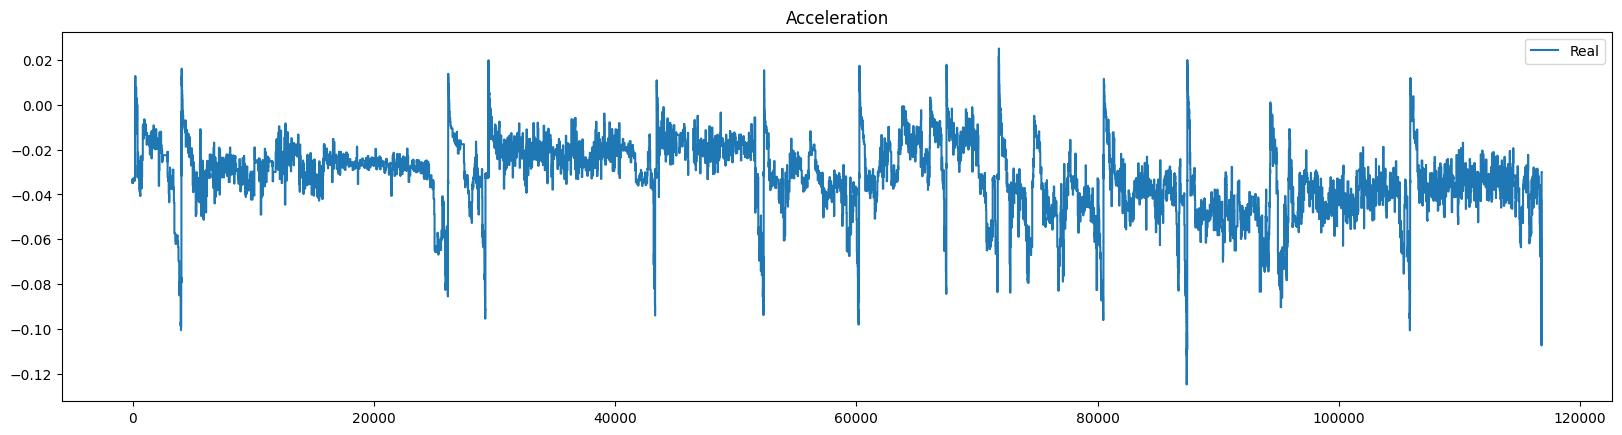

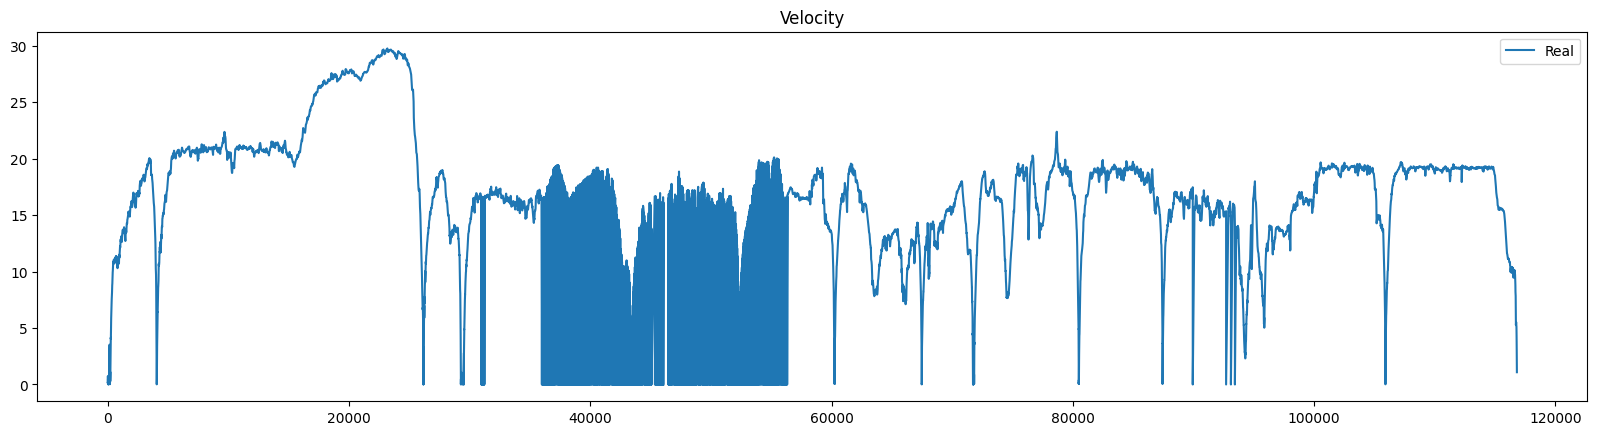

In [4]:
plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

### Funkce pro zpracování

In [5]:
def render_plot(title, x, ys, labels, width=20):
    plt.figure().set_figwidth(width)
    for y in ys:
        plt.plot(x, y)
    plt.title(title)
    if len(labels) > 0:
        plt.legend(labels, loc ="upper right")
    plt.show()

In [6]:
def map_velocity(df_measured, first_offset, velocity_fp):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    first_dist = df_measured["cumulative_distance_m"].iloc[0]
    for tv in track_velocity:
        start_in_m = tv["start"]*1000
        df_measured.loc[first_offset*1000 - (df_measured["cumulative_distance_m"]-first_dist) <= start_in_m, "track_velocity"] = tv["value"]

    df_measured["track_velocity_m_s"] = df_measured["track_velocity"]/3.6

In [7]:
def compare_data(df_measured, geojson_path: str):
    # # Data identification
    # data_name = os.path.basename(geojson_path).split(".")[0]

    # Calculated data
    c = tconsumption.Consumption()
    c.variable_params = {
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98
    }
    c.load_from_file(geojson_path)
    c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"])
    print("unique velocities in km/h", set([x*3.6 for x in df_measured["track_velocity_m_s"]]))

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 31490 + 33000

    # Running the simulation
    c.run()

    # Plotting
    render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], df_measured["gps_speed"], c.max_velocities_in_mps],
        ["Simulation", "Real", "Limit"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [df_measured["accel_proc_y"]],
        ["Real"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [c.series["acceleration_values"]],
        ["Simulation"]
    )

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"][:100],
    #     [c.series["acceleration_values"][:100]],
    #     ["Simulation (slice)"]
    # )

### Opava západ --> Krnov-Cvilín
> Vybrání části k sledování a předzpracování

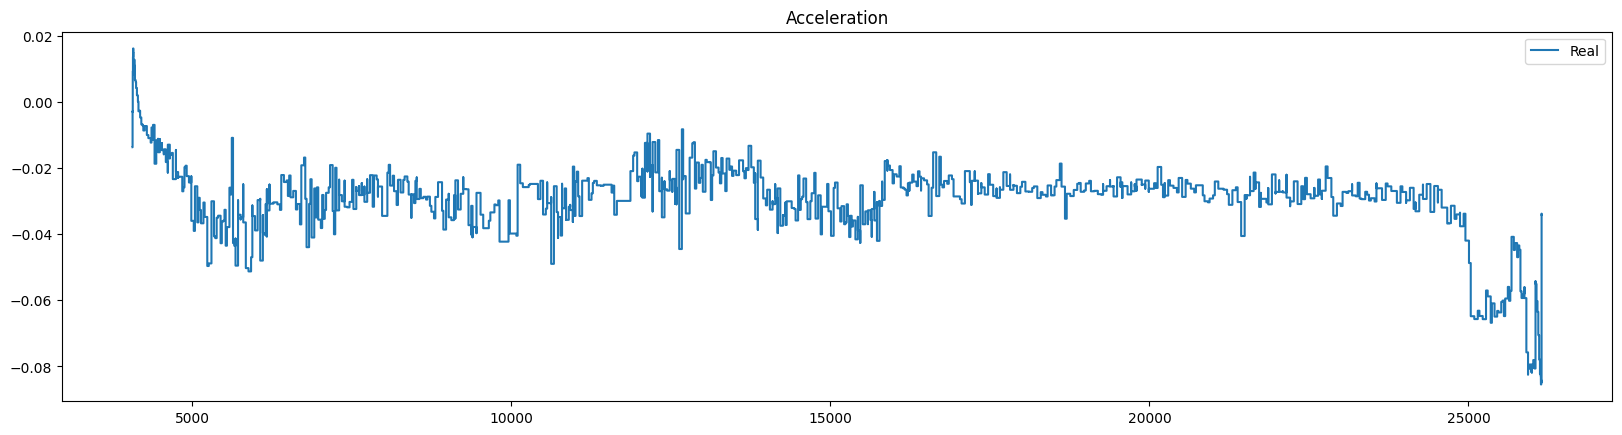

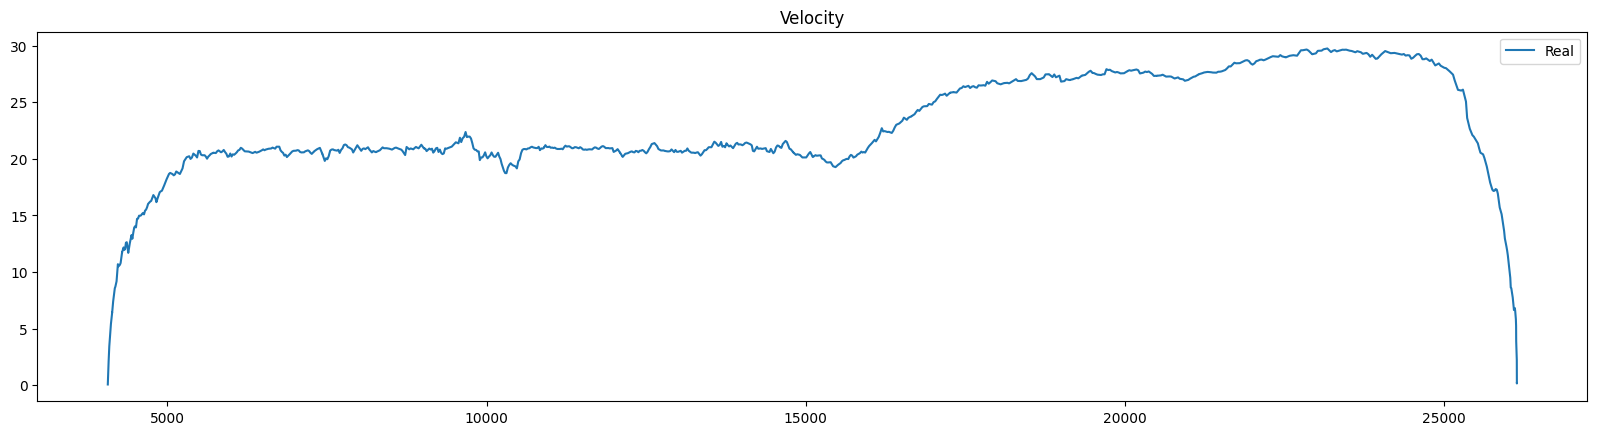

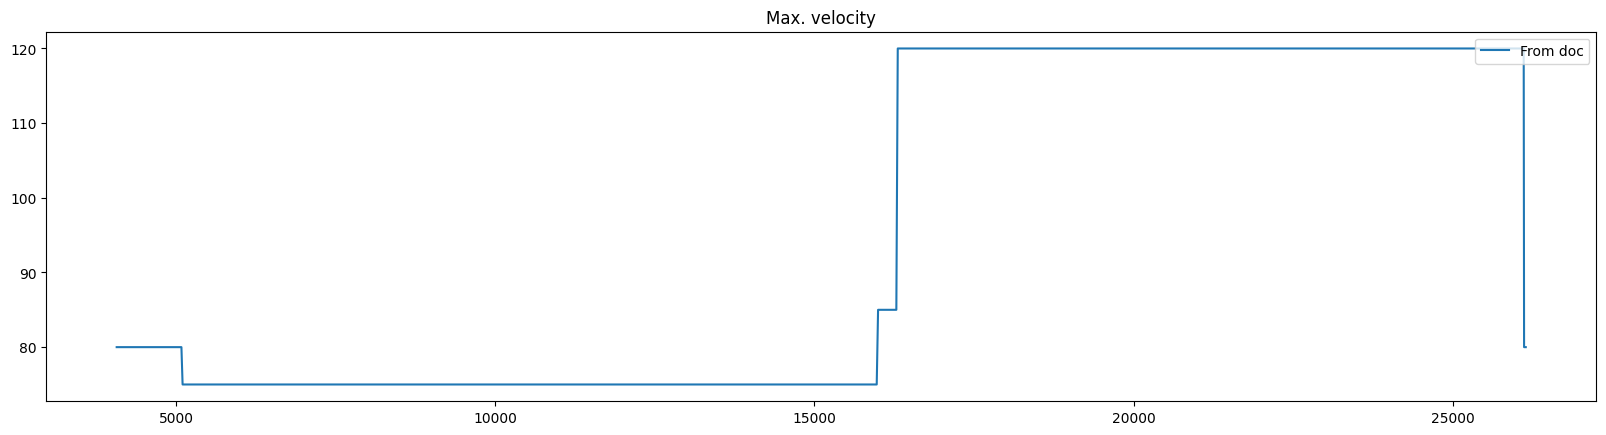

In [15]:
df_slice = df.loc[1080:3530] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 112.329, "../testing-data/velocity-data/310.json")

# Plots
render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [9]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

unique velocities in km/h {40.0, 50.0, nan, 60.00000000000001, nan, nan, nan, nan, nan, nan, nan, 75.0, nan, nan, 80.0, nan, nan, nan, 85.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

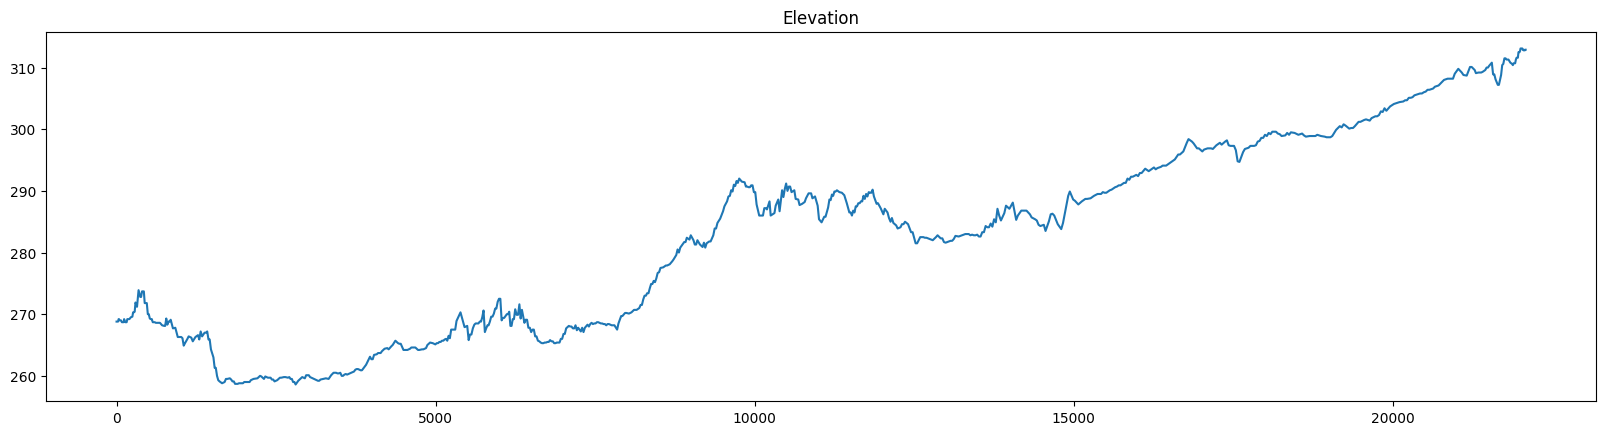

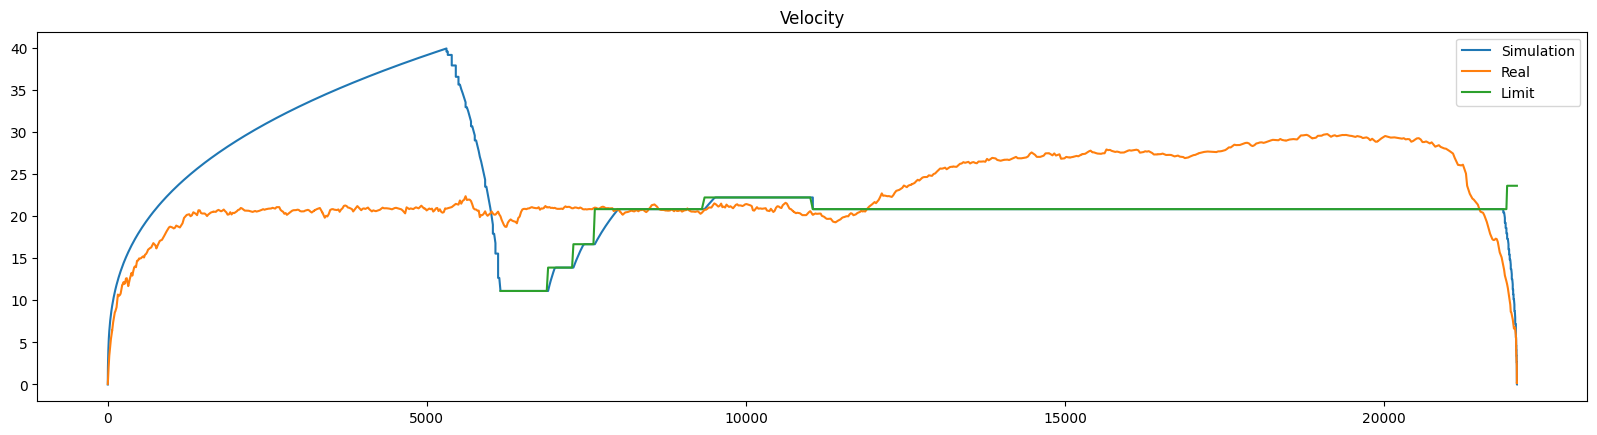

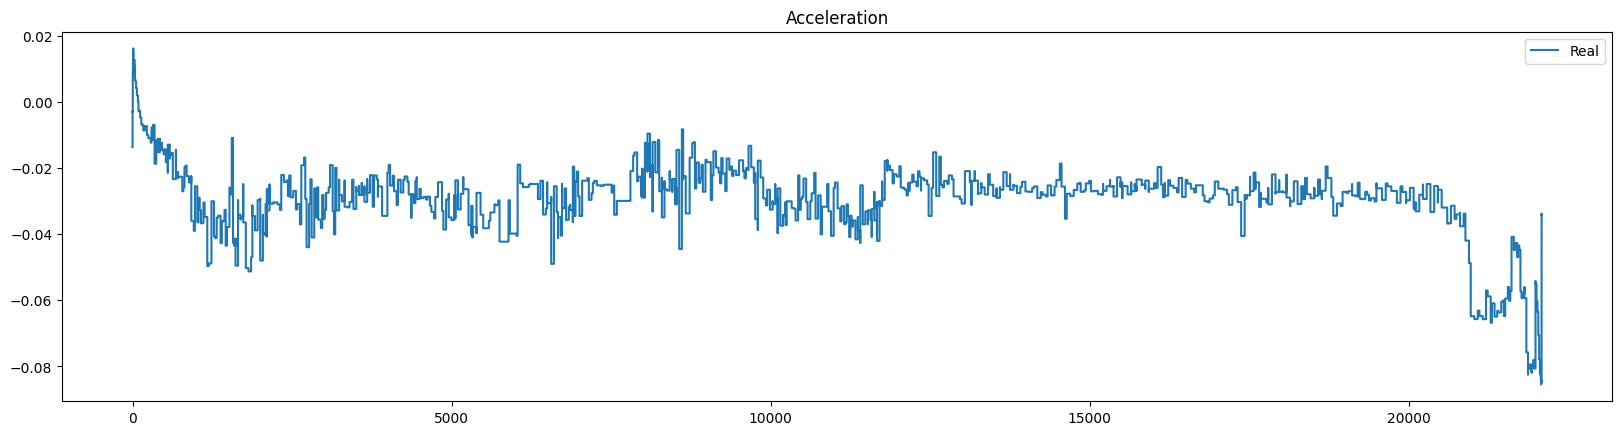

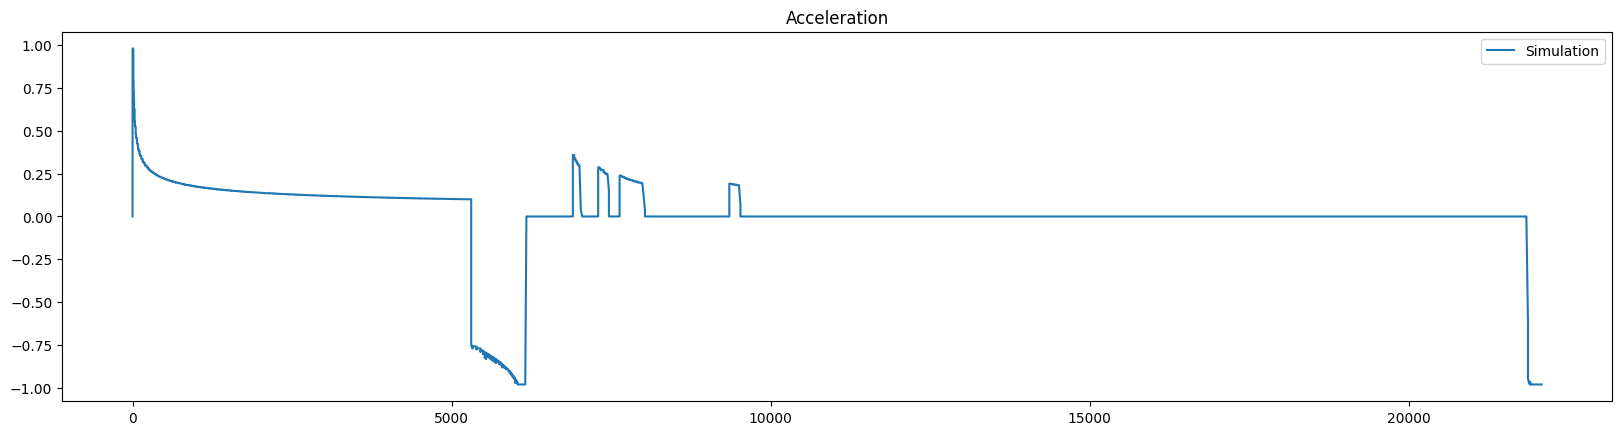

In [10]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson"
)

### Krnov-Cvilín --> Krnov
> Vybrání části k sledování a předzpracování

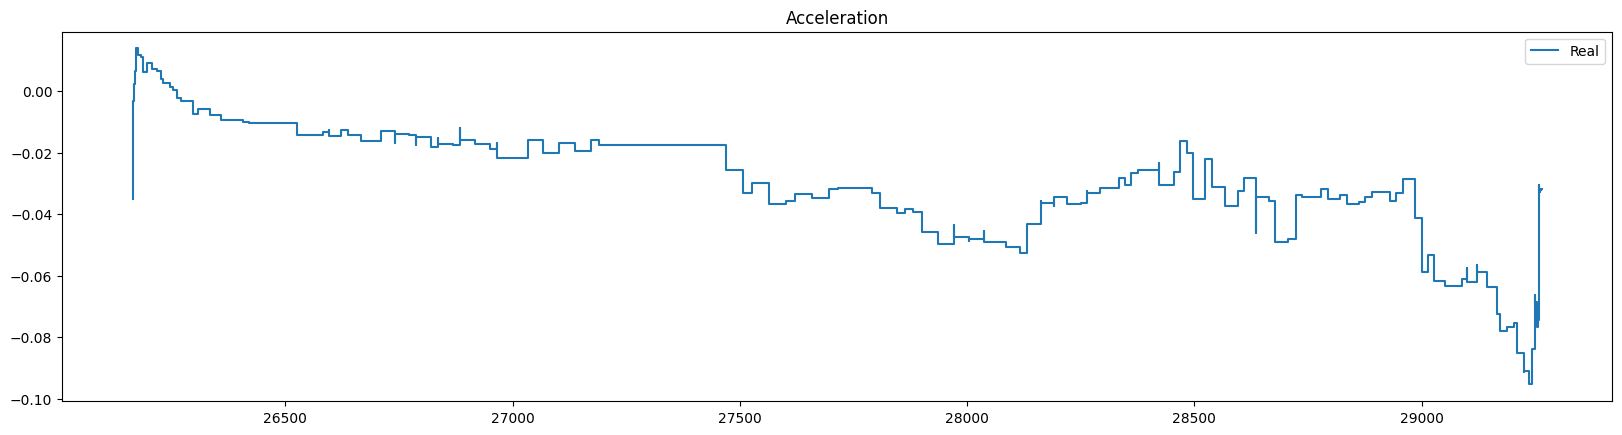

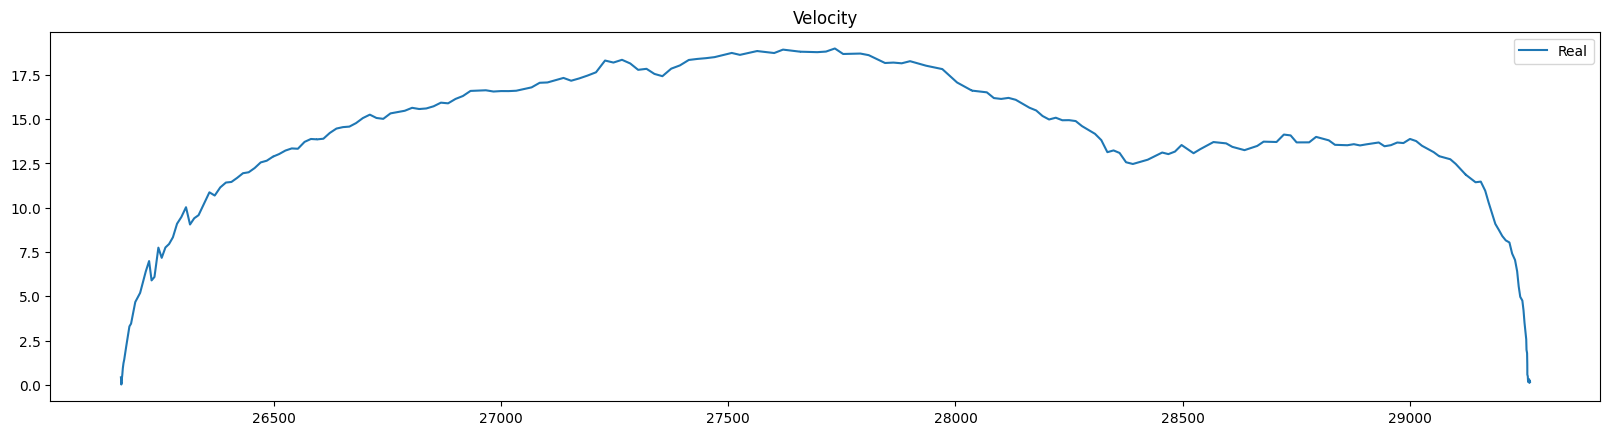

In [11]:
df_slice = df.loc[3680:4280] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 90.213, "../testing-data/velocity-data/310.json")

render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])

In [12]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

In [13]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson"
)

KeyError: 'track_velocity_m_s'

### Data z telefonu

In [ ]:
df_phone = pd.read_csv("/tmp/Accelerometer.csv", delimiter=",")[0:10000]

print(df_phone.shape[0])

render_plot(
    "Acceleration",
    df_phone["time"],
    [df_phone["x"]],
    ["x"]
)

render_plot(
    "Acceleration",
    df_phone["time"],
    [df_phone["y"]],
    ["y"]
)

render_plot(
    "Acceleration",
    df_phone["time"],
    [df_phone["z"]],
    ["z"]
)